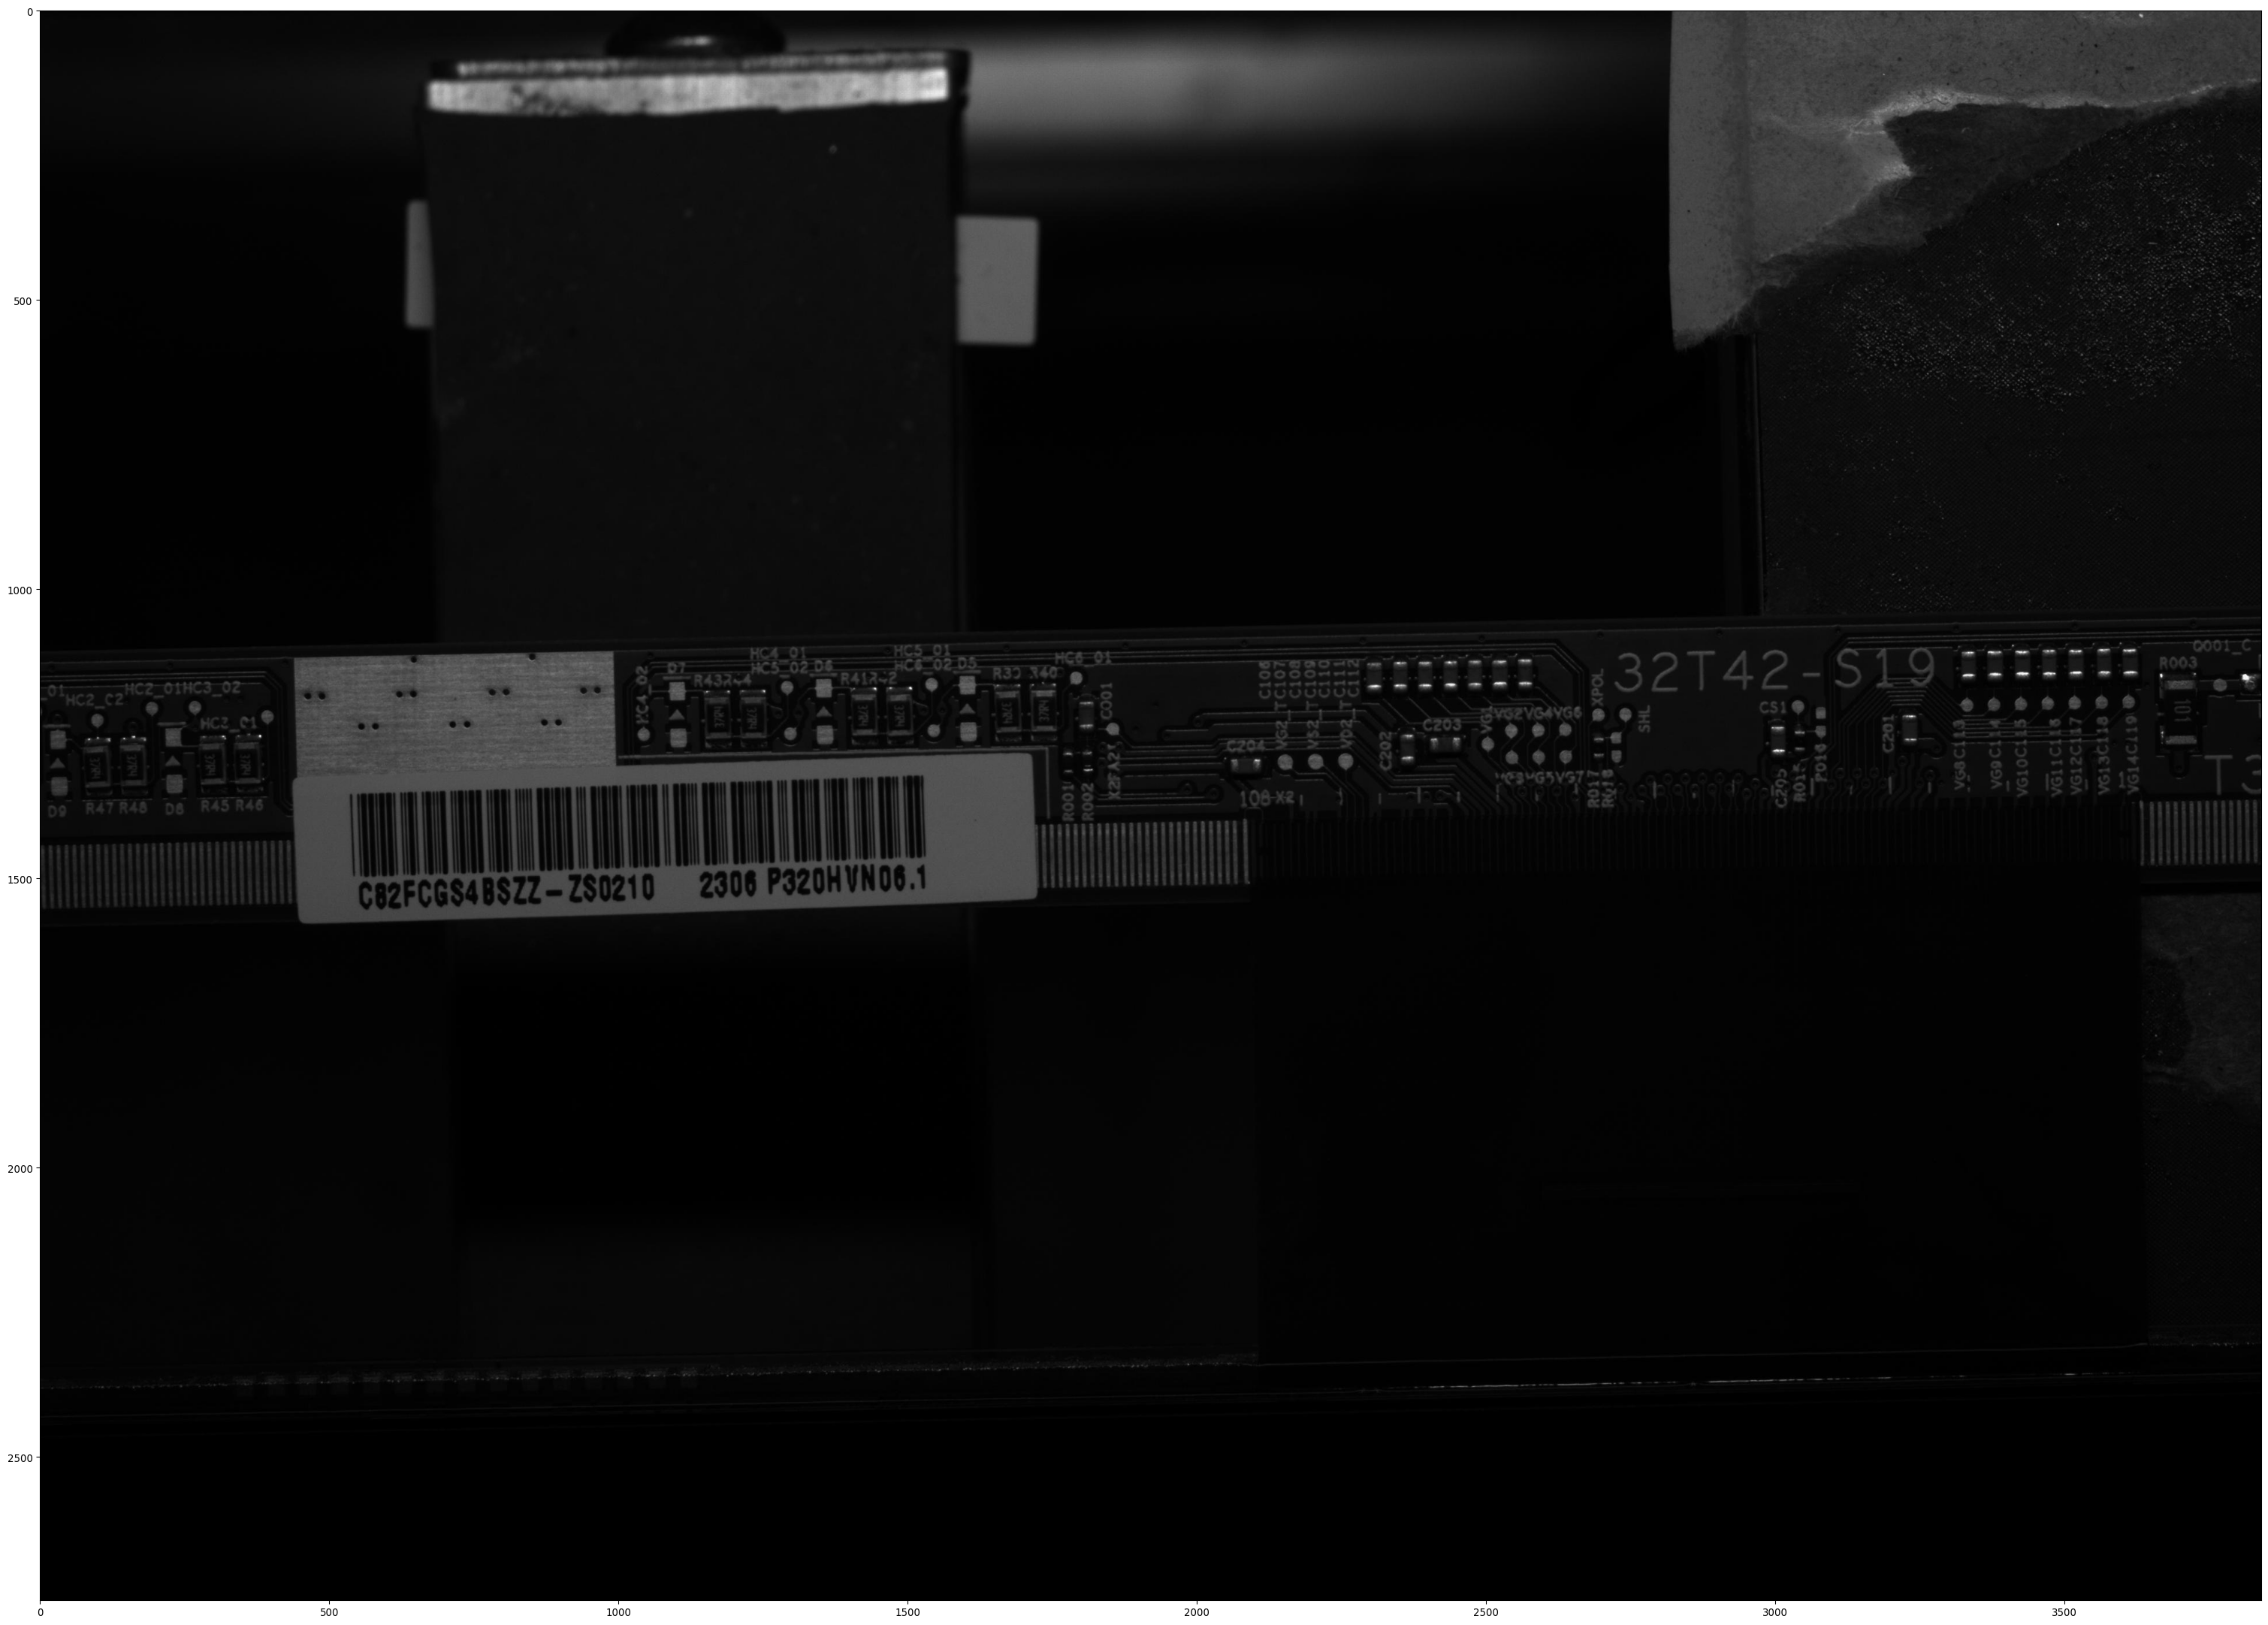

In [47]:
import cv2
import numpy as np
import imgaug as ia

BATCH_SIZE = 5
NB_BATCHES = 5

image = cv2.imread("D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C1\C10059.jpg", 1)
images = [np.copy(image) for _ in range(BATCH_SIZE)]
ia.imshow(image)

In [48]:
from imgaug.augmentables.batches import UnnormalizedBatch

batches = [UnnormalizedBatch(images=images) for _ in range(NB_BATCHES)]

In [49]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
	# iaa.PiecewiseAffine(scale=0.05, nb_cols=6, nb_rows=6),  # very slow
	iaa.Fliplr(0.5),  # very fast
	iaa.CropAndPad(px=(-10, 10)),  # very fast
	iaa.Affine(rotate=(-25, 25)),
	iaa.AdditiveGaussianNoise(scale=(10, 70)),
	iaa.Crop(percent=(0, 0.2)),
	iaa.AddToHueAndSaturation((-60, 60)),
	iaa.ElasticTransformation(alpha=90, sigma=9),
	iaa.Cutout(squared=False,fill_mode='gaussian'),
	iaa.PerspectiveTransform(scale=(0.0,0.1))
], random_order=True)

In [50]:
import time

time_start = time.time()
batches_aug = list(seq.augment_batches(batches, background=False))  # background=True for multicore aug
time_end = time.time()

print("Augmentation done in %.2fs" % (time_end - time_start,))
[cv2.imwrite(rf'C:\Users\fy.xie\Desktop\{index}.png', np.hstack(item.images_aug)) for index, item in enumerate(batches_aug)]
# ia.imshow(np.hstack(batches_aug[0].images_aug))


Augmentation done in 20.87s


[True, True, True, True, True]